# Folk Tale Sentiment Analysis 
# Final Project

Description:
This project analyzes the sentiment of 2,900+ folk tales from around the world. 
Using natural language processing (NLP), we explore how different cultures 
tell stories with positive, negative, or neutral tones.

Steps:
1. Load and clean the dataset (remove missing nations + exact duplicates)
2. Preprocess the story text (lowercase, remove stopwords, etc.)
3. Apply sentiment analysis to each story
4. Group and visualize sentiment by nation

Goal:
Understand emotional patterns across cultural storytelling 
and explore how folk tales differ by region.

@author: adriana alfaro

In [53]:
# import packages
import pandas as pd
import os

import matplotlib.pyplot as plt 

import re
import string

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


import re
import unicodedata

# set the working directory to where your project files are
os.chdir('/Users/adrianaalfaro/Documents/Folktale Sentiment Analysis')

# confirm it worked
print("current directory:", os.getcwd())

# load the csv into a dataframe
df = pd.read_csv("folk_tales_deduplicated.csv")

current directory: /Users/adrianaalfaro/Documents/Folktale Sentiment Analysis


## Exploring Folktale Data Set

total stories: 2938
unique nations: 57
average length: 9030.465282505105
shortest: 130
longest: 106121


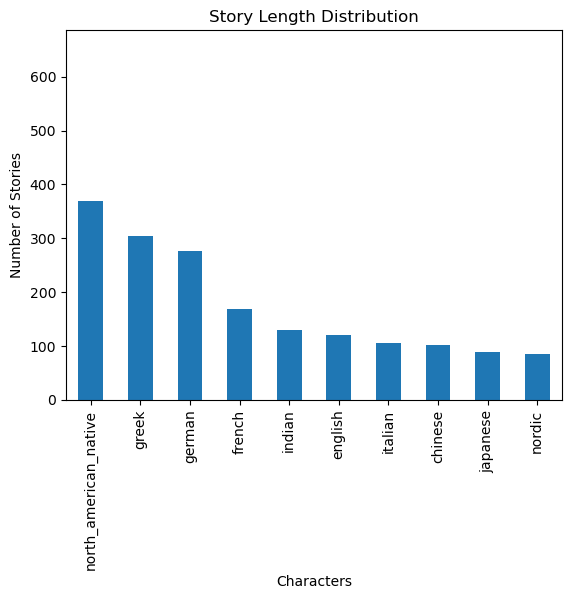

longest stories:
                         title        nation  story_length
53              The Ice Maiden        danish        106121
390  The Marsh King's Daughter  scandinavian         80113
284              The Blue Bird        french         74089

shortest stories:
                                                  title   nation  story_length
1236  The Dancing Water, the Singing Apple and the S...  italian           130
1213                             The Dog and the Oyster    greek           162
1438                            The Moon and Her Mother    greek           227


In [33]:
# how many stories we have in total 
print("total stories:", len(df))

# see how many unique nations are in the dataset 
print("unique nations:", df['nation'].nunique())

# which nations have the most stories
df['nation'].value_counts().head(10).plot(kind='bar',title='Top 10 Nations by Number of Stories')

# story length summary 
# add a column for story length
df['story_length'] = df['text'].str.len() 

# stats on how long the stories are
print("average length:", df['story_length'].mean())
print("shortest:", df['story_length'].min())
print("longest:", df['story_length'].max())

# visualize story length distribution 

# histogram of story lengths
plt.hist(df['story_length'], bins=50)
plt.title('Story Length Distribution')
plt.xlabel('Characters') 
plt.ylabel('Number of Stories') 
plt.show()

# show 3 longest and 3 shortest stories
print("longest stories:")
print(df.nlargest(3, 'story_length')[['title', 'nation', 'story_length']])

print("\nshortest stories:")
print(df.nsmallest(3, 'story_length')[['title', 'nation', 'story_length']])



## Clean Folktales for Sentiment Analysis

In [57]:
# clean the dataset for sentiment analysis

# drop rows where 'nation' or 'text' is missing
df = df.dropna(subset=['nation', 'text'])

# drop exact duplicates based on both title and text
df = df.drop_duplicates(subset=['title', 'text'])

# if the previous stopword-cleaned column exists, drop it 
# context: I originally removed stopwords, but decided to keep stopwords to use VADER
if 'clean_text' in df.columns:
    df.drop(columns=['clean_text'], inplace=True)

# define a VADER-optimized cleaning function

def clean_for_vader(text):
    # lowercase the text
    text = text.lower()
    
    # normalize unicode (like é to e)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode()
    
    # remove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # remove extra spaces and line breaks
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# apply the cleaning to a new column
df['vader_ready_text'] = df['text'].apply(clean_for_vader)

# quick check
print("shape after cleaning:", df.shape)
df[['title', 'nation', 'vader_ready_text']].head()


# cleaning completed successfully check
print("\nCleaning Completed Successfully!")

shape after cleaning: (2929, 5)

Cleaning Completed Successfully!


## Sentiment Analysis With VADER

In [59]:
# download the VADER lexicon
nltk.download('vader_lexicon')

# initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

# apply VADER to the cleaned story text
df['sentiment_score'] = df['vader_ready_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# turn score into a sentiment label
def label_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)

# quick preview
df[['title', 'nation', 'sentiment_score', 'sentiment']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/adrianaalfaro/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,title,nation,sentiment_score,sentiment
0,Momotaro,japanese,0.9989,positive
1,The Birdcatcher,serbian,0.6219,positive
2,Sharing Joy and Sorrow,german,0.9900,positive
3,The Punishment of Gangana,french,0.9997,positive
4,The Peace with the Snakes,north_american_native,0.8830,positive


## Visualize overall sentiment distribution 

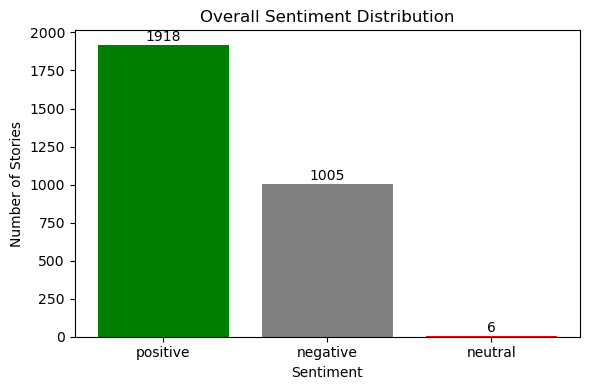

In [65]:
# count sentiment categories
sentiment_counts = df['sentiment'].value_counts().sort_values(ascending=False)

# plot with labels on each bar
plt.figure(figsize=(6, 4))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'])
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Stories')
plt.xticks(rotation=0)

# add numeric labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()



## Visualize Sentiment by Nation (Top 10)

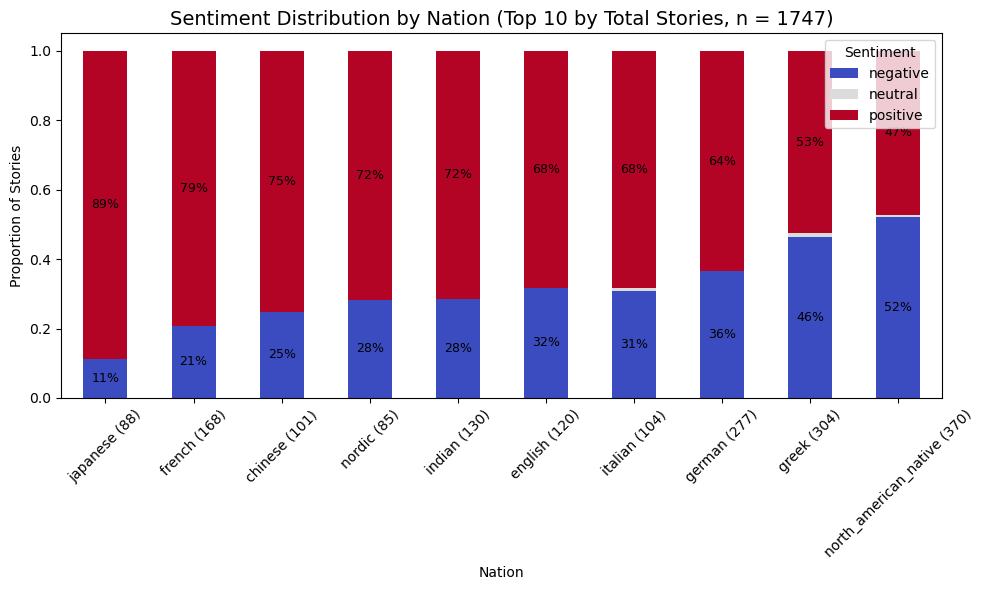

In [80]:
# top 10 nations by number of stories
top_nations = df['nation'].value_counts().head(10).index.tolist()
filtered_df = df[df['nation'].isin(top_nations)]
total_top_stories = filtered_df.shape[0]

# calculate proportions
nation_sentiment_pct = (
    filtered_df.groupby(['nation', 'sentiment'])
    .size()
    .unstack(fill_value=0)
    .div(filtered_df.groupby('nation').size(), axis=0)
)

# adding story count per nation
nation_counts = filtered_df['nation'].value_counts()
nation_sentiment_pct.index = [f"{nation} ({nation_counts[nation]})" for nation in nation_sentiment_pct.index]


# sort by % positive
if 'positive' in nation_sentiment_pct.columns:
    nation_sentiment_pct = nation_sentiment_pct.sort_values(by='positive', ascending=False)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
nation_sentiment_pct.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm')

# updated title with story count
ax.set_title(f"Sentiment Distribution by Nation (Top 10 by Total Stories, n = {total_top_stories})", fontsize=14)
ax.set_xlabel("Nation")
ax.set_ylabel("Proportion of Stories")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", loc="upper right")

# add percentage labels to each bar segment
for i, (nation, row) in enumerate(nation_sentiment_pct.iterrows()):
    cumulative = 0
    for sentiment in nation_sentiment_pct.columns:
        height = row[sentiment]
        if height > 0.03:
            ax.text(
                i, cumulative + height / 2, f"{height:.0%}",
                ha='center', va='center', fontsize=9
            )
        cumulative += height

plt.tight_layout()
plt.show()


> **Note:** The second chart highlights lesser-represented countries with fewer than 10 stories.  
> While sample sizes are small, we include them to ensure cultural inclusivity and representation in sentiment trends.


## Visualize sentiment for countries with fewer than 10 stories

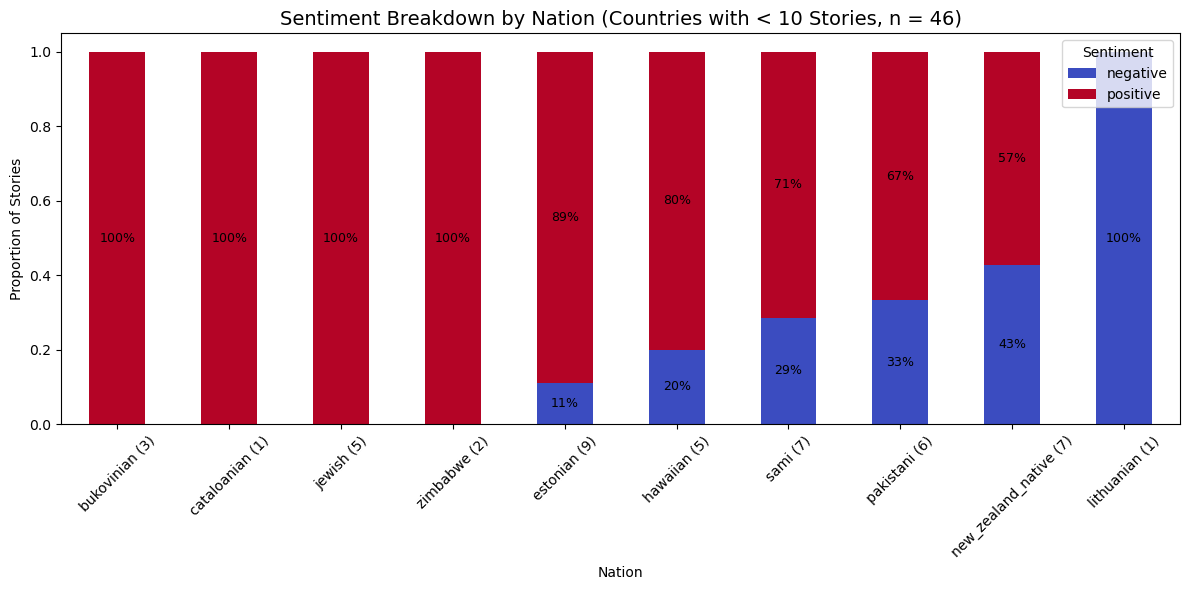

In [82]:
low_story_nations = df['nation'].value_counts()[df['nation'].value_counts() < 10].index.tolist()
low_df = df[df['nation'].isin(low_story_nations)]
total_low_stories = low_df.shape[0]

# calculate normalized proportions
low_sentiment_pct = (
    low_df.groupby(['nation', 'sentiment'])
    .size()
    .unstack(fill_value=0)
    .div(low_df.groupby('nation').size(), axis=0)
)

# adding story count per nation
low_counts = low_df['nation'].value_counts()
low_sentiment_pct.index = [f"{nation} ({low_counts[nation]})" for nation in low_sentiment_pct.index]


# sort by % positive
if 'positive' in low_sentiment_pct.columns:
    low_sentiment_pct = low_sentiment_pct.sort_values(by='positive', ascending=False)

# plot
fig, ax = plt.subplots(figsize=(12, 6))
low_sentiment_pct.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm')

# title with total count
ax.set_title(f"Sentiment Breakdown by Nation (Countries with < 10 Stories, n = {total_low_stories})", fontsize=14)
ax.set_xlabel("Nation")
ax.set_ylabel("Proportion of Stories")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", loc="upper right")

# add percentage labels
for i, (nation, row) in enumerate(low_sentiment_pct.iterrows()):
    cumulative = 0
    for sentiment in low_sentiment_pct.columns:
        height = row[sentiment]
        if height > 0.03:
            ax.text(
                i, cumulative + height / 2, f"{height:.0%}",
                ha='center', va='center', fontsize=9
            )
        cumulative += height

plt.tight_layout()
plt.show()


## LDA theme modeling + sentiment breakdown by theme

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text

# prepare text data
lda_texts = df['vader_ready_text'].dropna().tolist()

# define expanded custom stopwords
custom_stopwords = text.ENGLISH_STOP_WORDS.union([
    'said', 'came', 'went', 'like', 'one', 'day', 'man',
    'little', 'time', 'old', 'king', 'did', 'great',
    'boy', 'girl', 'story', 'tale', 'asked', 'replied',
    'happened', 'got', 'told', 'tell', 'thing', 'long', 'just', 'saw'
])

# vectorize with bigrams included
vectorizer = CountVectorizer(
    max_df=0.90,
    min_df=3,
    stop_words=list(custom_stopwords),
    ngram_range=(1, 2)
)
dtm = vectorizer.fit_transform(lda_texts)

# Run LDA with more components
lda_model = LatentDirichletAllocation(n_components=6, random_state=42)
lda_model.fit(dtm)

# Print top words for each theme
print("\n Top 10 Words Per Theme:\n")
for idx, topic in enumerate(lda_model.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Theme {idx+1}: {', '.join(top_words)}")

# Assign dominant theme to each story
topic_assignments = lda_model.transform(dtm).argmax(axis=1)

# Add theme back to DataFrame
df = df.loc[df['vader_ready_text'].notna()].copy()
df['lda_theme'] = topic_assignments



 Top 10 Words Per Theme:

Theme 1: tree, mother, wife, took, house, woman, come, home, away, good
Theme 2: away, young, son, father, daughter, wife, took, come, princess, prince
Theme 3: shall, head, prince, stood, beautiful, sea, come, away, princess, thou
Theme 4: den, wolf, ou jackalse, come, jackalse, yust, monkey, dat, ses, ou
Theme 5: make, good, children, night, men, come, says, away, water, people
Theme 6: night, son, head, sea, took, men, water, come, away, giant
